### Set up notebook

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
sns.set_theme(context="notebook")

In [4]:
nvals = 24*4

### Import raw power data and compute coefficients

In [5]:
filepath = Path('.') / "layouts" / "EWELD" / "Electricity Consumption" / "C" / "C10 Manufacture of food products"
filesnames = ["U" + str(i) + ".csv" for i in range(11, 19)]
dfs = {f: pd.read_csv(filepath / f, header=0, index_col=0, parse_dates=True) for f in filesnames}
for f in dfs:
    df = dfs[f]
    df.rename(mapper={"Value":"Power Load [kWh]"}, inplace=True, axis=1)
    df['Yearly Power Load [kWh]'] = df.groupby(df.index.year)["Power Load [kWh]"].transform('sum')
    df['Power cw'] = df.groupby(df.index.isocalendar().week + df.index.year*53)["Power Load [kWh]"].transform("sum") / df['Yearly Power Load [kWh]']
    df['Power cd'] = df.groupby(df.index.dayofyear + df.index.year*366)["Power Load [kWh]"].transform("sum") / (df['Power cw']*df['Yearly Power Load [kWh]'])
    df['Power c15m'] = df["Power Load [kWh]"] / (df['Power cd']*df['Power cw']*df['Yearly Power Load [kWh]'])

### Make heat coefficients

In [6]:
for f in dfs:
    df = dfs[f]
    df['Heat c15m'] = df['Power c15m'].rolling(window=11, center=True).mean()

### Replace annual heat and power consumption

In [7]:
# From IAC, California, 
powerLoadYearly = 10000 # MWh
heatLoadYearly = 100000 # MMBtu
powerLoadYearly = 1000 * powerLoadYearly # kWh
heatLoadYearly = 293.07 * heatLoadYearly # kWh
print("power load", powerLoadYearly/1000000, "GWh", "heat load", heatLoadYearly/1000000, "GWh")

power load 10.0 GWh heat load 29.307 GWh


In [8]:
# This method normalizes every year to be the same as the IAC data, but we should not use multi year data
for f in dfs:
    df = dfs[f]
    df['Yearly Power Load [kWh]'] = powerLoadYearly / df['Yearly Power Load [kWh]'] * df['Yearly Power Load [kWh]']
    df['Yearly Heat Load [kWh]'] = heatLoadYearly / df['Yearly Power Load [kWh]'] * df['Yearly Power Load [kWh]']
    df['Power Load [kWh]'] = df['Yearly Power Load [kWh]'] * df['Power cw'] * df['Power cd'] * df['Power c15m']
    df['Heat Load [kWh]'] = df['Yearly Heat Load [kWh]'] * df['Power cw'] * df['Power cd'] * df['Heat c15m']

## Plots

In [9]:
def pivot_column(df, column):
    col = df[[column]].copy()
    col['date'] = col.index.date
    col['time'] = col.index.time
    col = col.pivot(index='time', columns='date', values=column)
    return df.pivot_table(index=df.index.time, columns=df.index.date, values=column)

In [10]:
def plot_heatmaps(df):
    pwr = pivot_column(df, 'Power Load [kWh]')
    heat = pivot_column(df, 'Heat Load [kWh]')
    fig, axs = plt.subplots(2, 1, figsize=(12, 7))
    sns.heatmap(pwr, cmap='coolwarm', cbar_kws={'label': 'Power Load [kWh]'}, ax=axs[0], robust=True)
    axs[0].set_title('Power Load')
    sns.heatmap(heat, cmap='coolwarm', cbar_kws={'label': 'Heat Load [kWh]'}, ax=axs[1], robust=True)
    axs[1].set_title('Heat Load')
    plt.tight_layout()  # Adjust layout to prevent overlap
    return plt.gca()

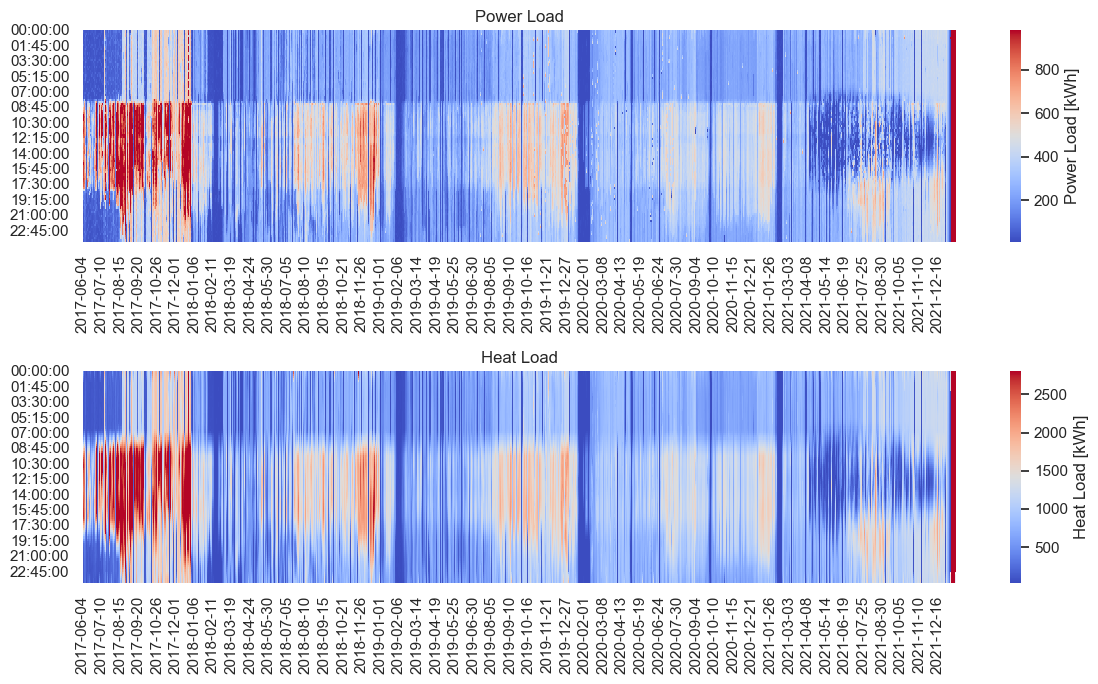

In [11]:
f = filesnames[0]
plot_heatmaps(dfs[f]);

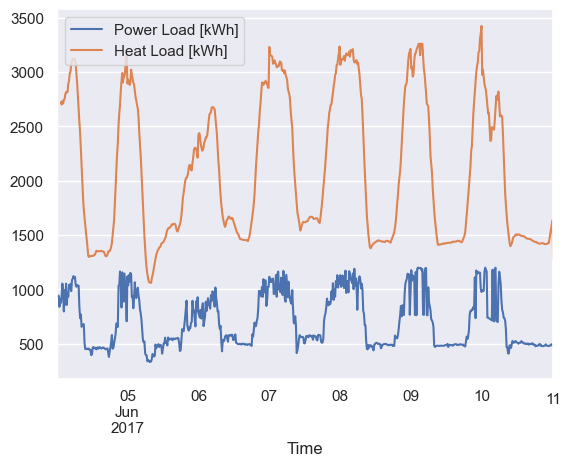

In [12]:
df[:24*4*7][['Power Load [kWh]', 'Heat Load [kWh]']].plot();

## Choose 1 year of data for each site and save as a csv

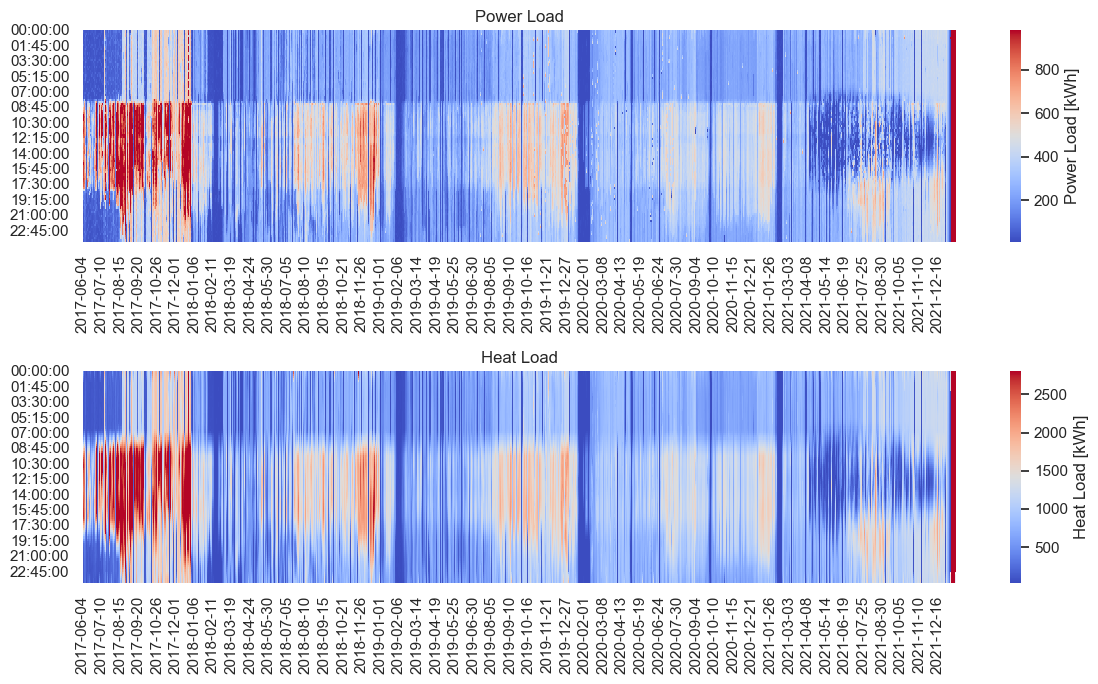

In [13]:
f = filesnames[0]
plot_heatmaps(dfs[f]);

first clean site. Let's use it.

In [14]:
savepath = Path('.') / "layouts" / "loads" / "site1_load.csv"
dfs[f].loc['2019', ['Power Load [kWh]', 'Heat Load [kWh]']].fillna(0).to_csv(savepath)

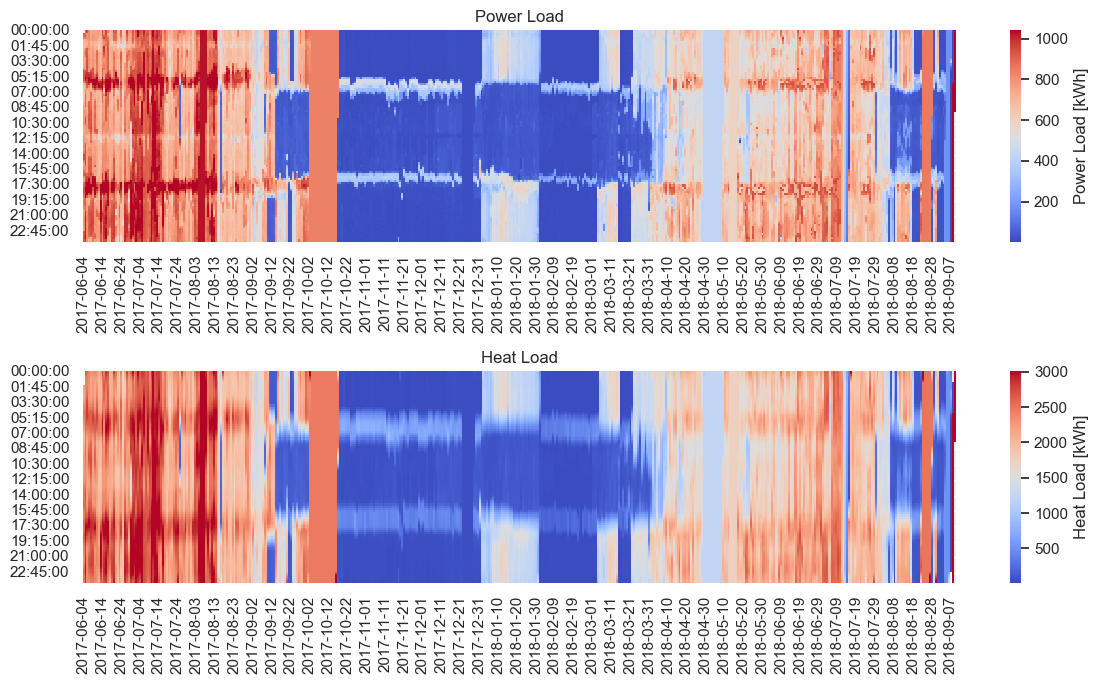

In [15]:
f = filesnames[1]
plot_heatmaps(dfs[f]);

Not clean enough, we won't use it for now.

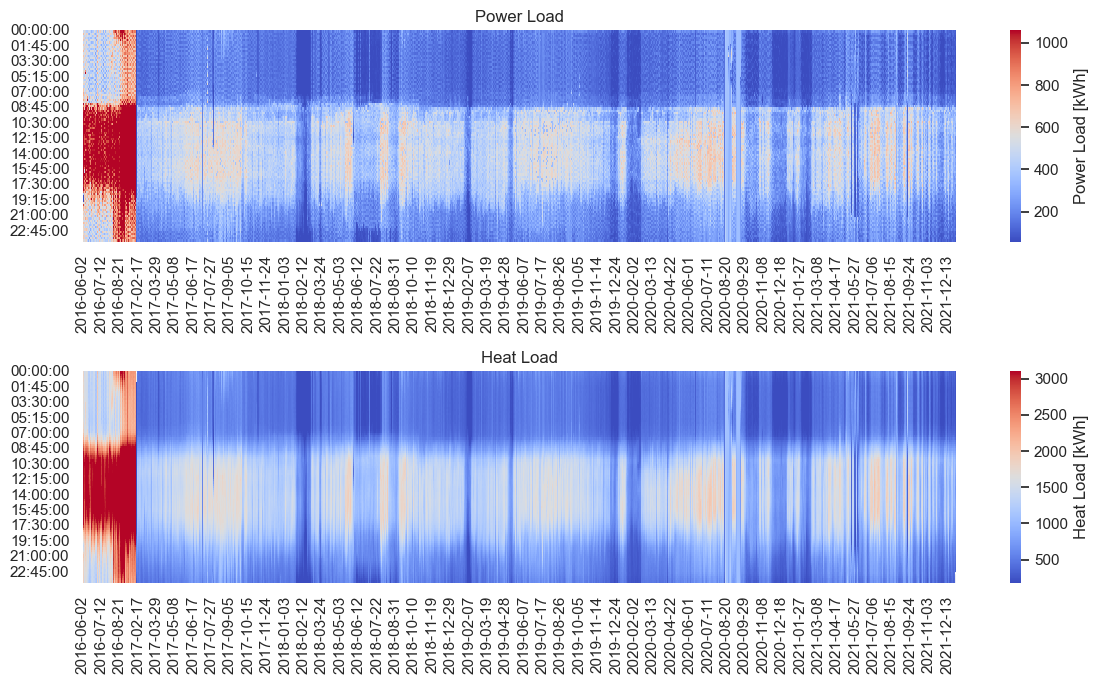

In [16]:
f = filesnames[2]
plot_heatmaps(dfs[f]);

Nice one, second site.

In [17]:
savepath = Path('.') / "layouts" / "loads" / "site2_load.csv"
dfs[f].loc['2019', ['Power Load [kWh]', 'Heat Load [kWh]']].fillna(0).to_csv(savepath)

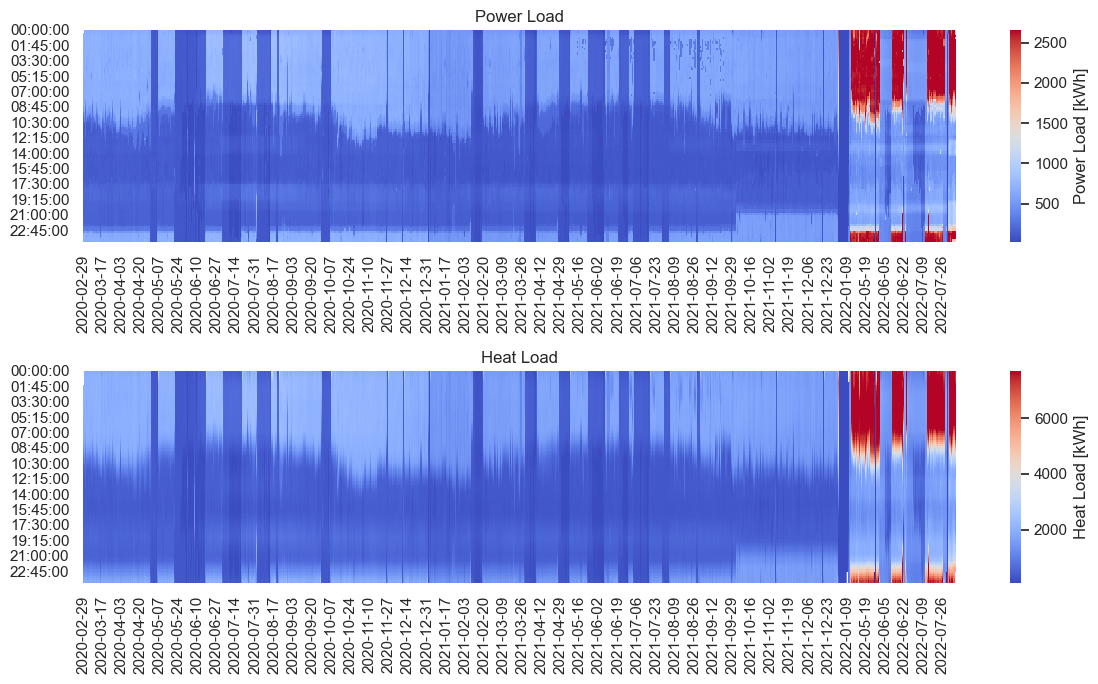

In [18]:
f = filesnames[3]
plot_heatmaps(dfs[f]);

Let's use it too, third site

In [19]:
savepath = Path('.') / "layouts" / "loads" / "site3_load.csv"
dfs[f].loc['2021', ['Power Load [kWh]', 'Heat Load [kWh]']].fillna(0).to_csv(savepath)

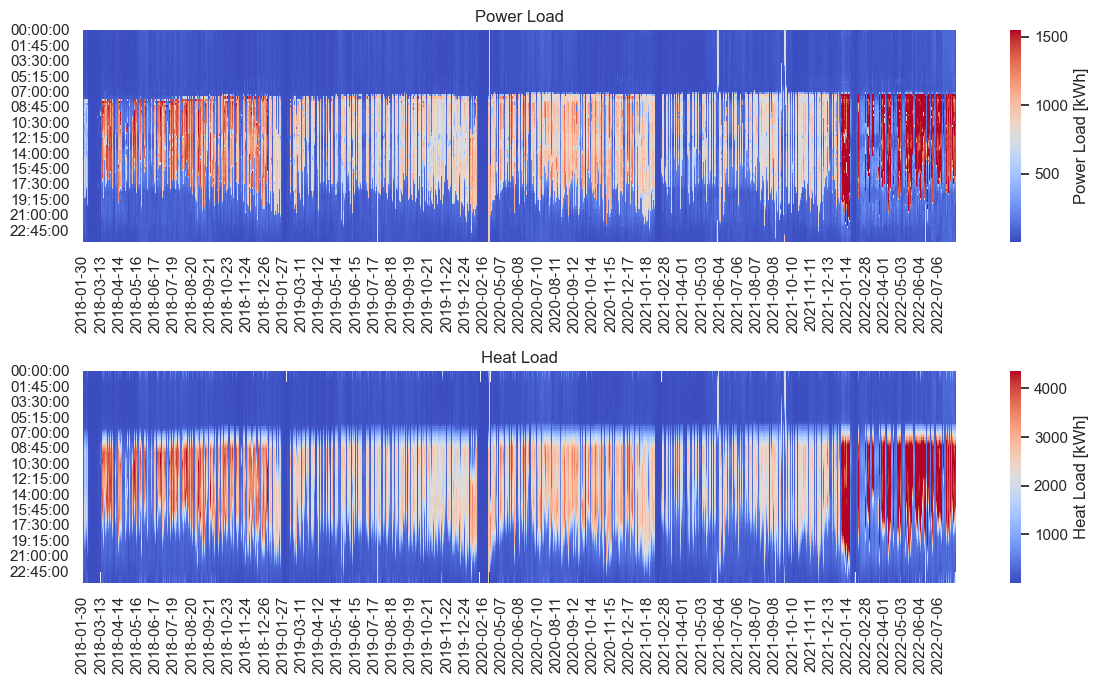

In [20]:
f = filesnames[4]
plot_heatmaps(dfs[f]);

4th site

In [21]:
savepath = Path('.') / "layouts" / "loads" / "site4_load.csv"
dfs[f].loc['2019', ['Power Load [kWh]', 'Heat Load [kWh]']].fillna(0).to_csv(savepath)

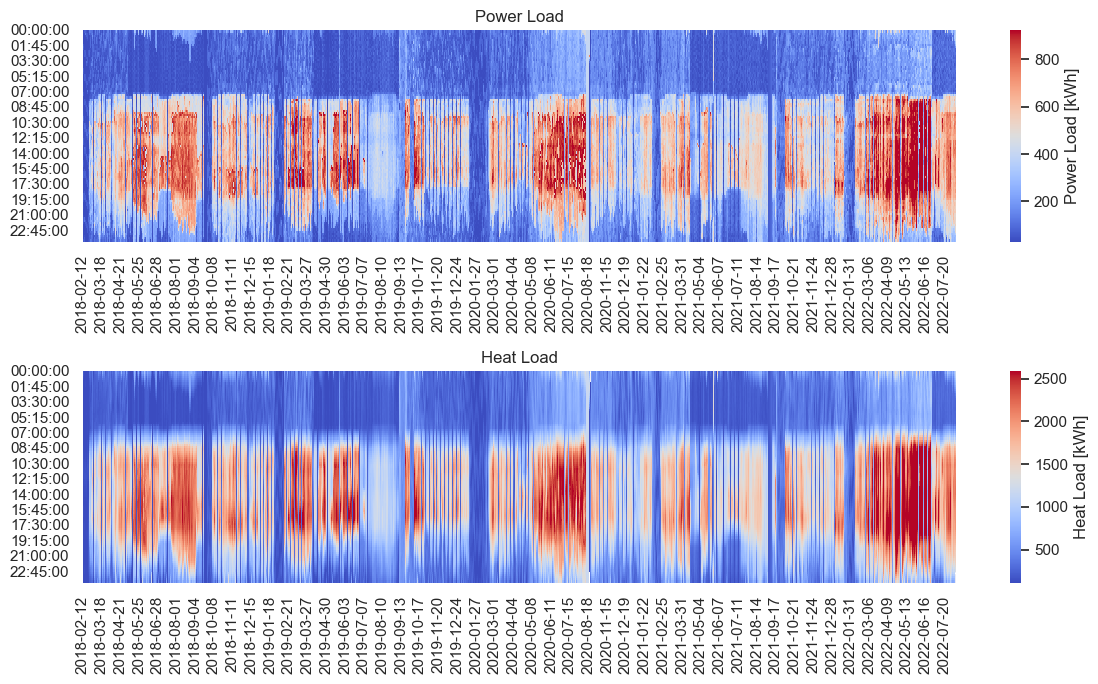

In [22]:
f = filesnames[5]
plot_heatmaps(dfs[f]);

Let's not use it for now.

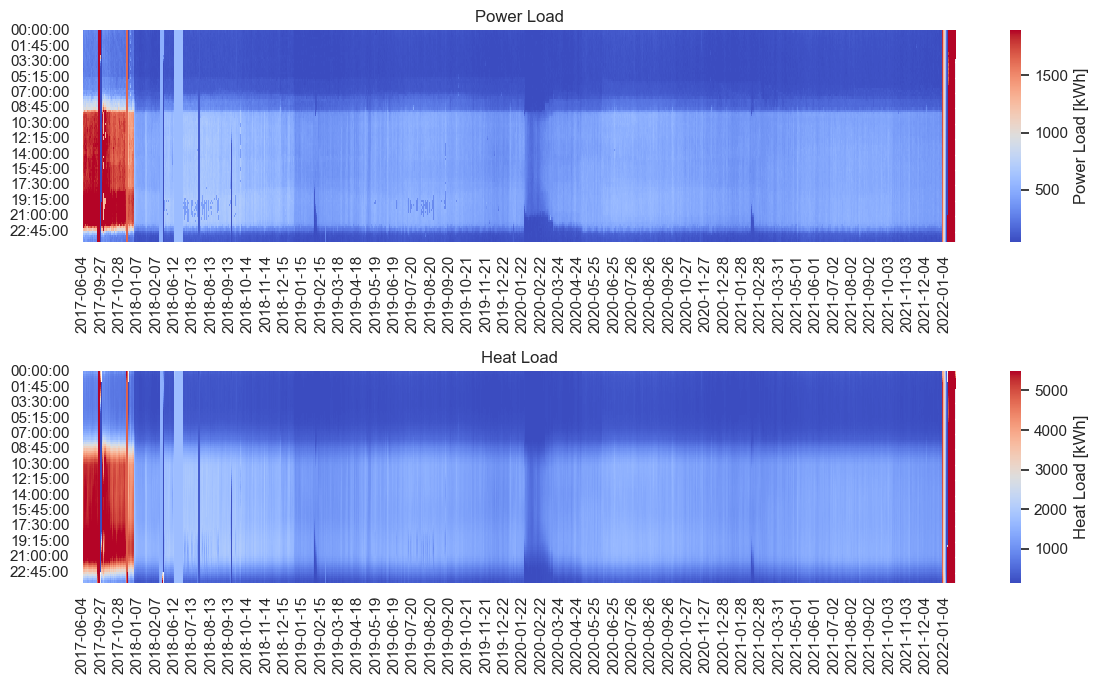

In [23]:
f = filesnames[6]
plot_heatmaps(dfs[f]);

Good one. 5th site.

In [24]:
savepath = Path('.') / "layouts" / "loads" / "site5_load.csv"
dfs[f].loc['2019', ['Power Load [kWh]', 'Heat Load [kWh]']].fillna(0).to_csv(savepath)

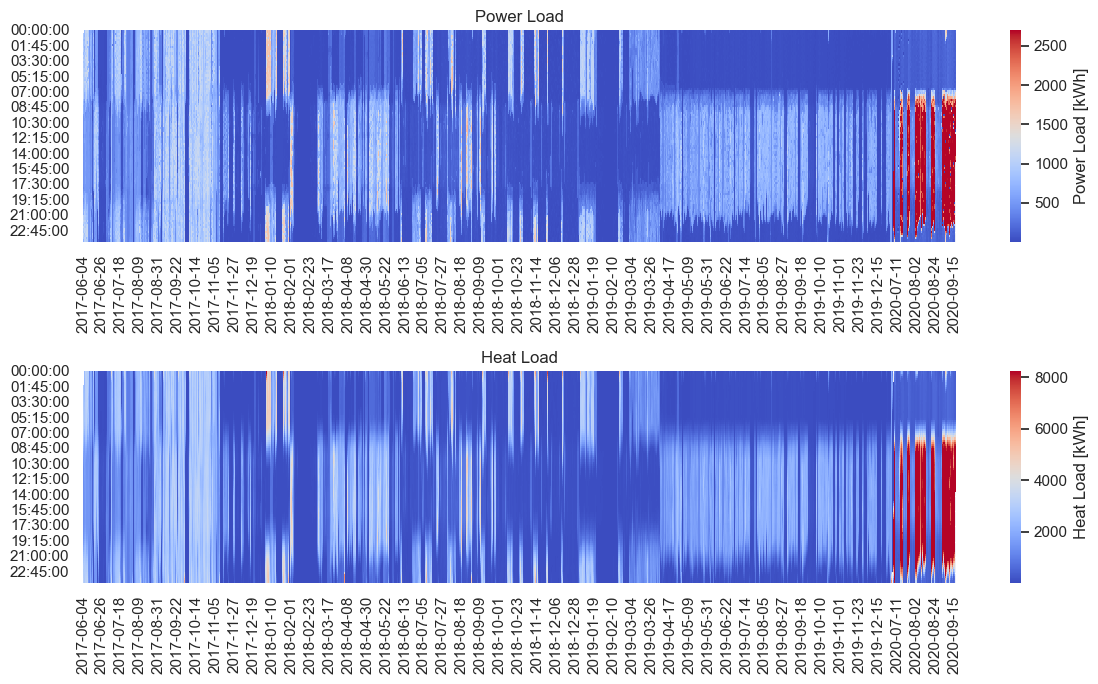

In [25]:
f = filesnames[7]
plot_heatmaps(dfs[f]);

nope, very clumsy